<a href="https://colab.research.google.com/github/0929230515jimmy/Tigers/blob/main/Deep_Learning_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Libraries and Data


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten



# Setting Seeds
np.random.seed(42)
tensorflow.random.set_seed(42)

# Loading Datasets
# Note: You'll have to upload the file into the "Files" tab each time you load up Colab for Colab to recognize the data.
dat_1 = pd.read_csv("pitches_dataset_2_final.csv", engine='python') # Connor base data that has no X's for type column
dat_2 = pd.read_csv("pitches_dataset_1_final.csv", engine='python') # Chin-yu base data
dat_3 = pd.read_csv("pitches_dataset_1_final.csv", engine='python') # Kael base data

In [ ]:
dat_1 = dat_1.dropna()
dat_2 = dat_2.dropna()
dat_3 = dat_3.dropna()

In [ ]:
dat_1 = dat_1.drop(columns = ["pitch_name", "Unnamed: 0"]) # forgot to ignore index when I converted df to csv so Unamed: 0 is former index column
dat_2 = dat_2.drop(columns = ["pitch_name", "Unnamed: 0"])
dat_3 = dat_3.drop(columns = ["pitch_name", "Unnamed: 0"])

In [ ]:
# Just in case we want this for making the output more readble when reporting results
mapping_pitchname = {'FF': '4-Seam Fastball', 'SL': 'Slider', 'SI': 'Sinker', 'CH': 'Changeup', 'FC': 'Cutter', 'CU': 'Curveball', 'ST': 'Sweeper',
                     'FS': 'Split-Finger', 'KC': 'Knuckle Curve', 'SV': 'Slurve', 'FO': 'Forkball', 'EP': 'Eephus', 'KN': 'Knuckleball'}

In [ ]:
# Connor Data (won't use zone, pitch_type, plate_x, or plate_z columns)
#mapping_pitchtype = {'FF': 0, 'SL': 1, 'SI': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'ST': 6, 'FS': 7, 'KC': 8, 'SV': 9, 'FO': 10, 'EP': 11, 'KN': 12}
mapping_stand = {'R': 0, 'L': 1}
mapping_throw = {'R': 0, 'L': 1}
mapping_type = {'S': 0, 'B': 1, 'X': 2}
#dat_1['pitch_type_vector'] = dat_1["pitch_type"].map(mapping_pitchtype)
dat_1['stand_vector'] = dat_1["stand"].map(mapping_stand)
dat_1['throw_vector'] = dat_1["p_throws"].map(mapping_throw)
dat_1['type_vector'] = dat_1["type"].map(mapping_type)

dat_1 = dat_1.drop(columns = ["pitch_type", 'stand', 'p_throws', 'zone', 'plate_x', 'plate_z', 'type']) # Drop type because it was replaced with type vector

In [ ]:
print("Number of input variables to predict 'type' (B or S):",len(dat_1.columns)-1)

Number of input variables to predict 'type' (B or S): 20


In [ ]:
# Chin-yu Data (won't use type or zone columns)
mapping_pitchtype = {'FF': 0, 'SL': 1, 'SI': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'ST': 6, 'FS': 7, 'KC': 8, 'SV': 9, 'FO': 10, 'EP': 11, 'KN': 12}
mapping_stand = {'R': 0, 'L': 1}
mapping_throw = {'R': 0, 'L': 1}
dat_2['pitch_type_vector'] = dat_2["pitch_type"].map(mapping_pitchtype)
dat_2['stand_vector'] = dat_2["stand"].map(mapping_stand)
dat_2['throw_vector'] = dat_2["p_throws"].map(mapping_throw)
dat_2 = dat_2.drop(columns = ["pitch_type", 'stand', 'p_throws','type', 'zone'])

In [ ]:
dat_2.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'spin_axis', 'pitch_type_vector', 'stand_vector',
       'throw_vector'],
      dtype='object')

In [ ]:
print("Number of input variables to predict 'pitch_type':",len(dat_2.columns)-1) # NOTE the 2 extra are plate_x and plate_z

Number of input variables to predict 'pitch_type': 22


In [ ]:
# Kael Data (won't use type, pitch_type columns, plate_x, or plate_z columns)
mapping_stand = {'R': 0, 'L': 1}
mapping_throw = {'R': 0, 'L': 1}
mapping_type = {'S': 0, 'B': 1}
# convert zone which is 1-9 for strike zone and 11-14 for balls to 0-8 for strikes and 9-12 for balls
# has to be done for proper formatting of softmax output
mapping_zone = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 11: 9, 12: 10, 13: 11, 14: 12}

dat_3['stand_vector'] = dat_3["stand"].map(mapping_stand)
dat_3['throw_vector'] = dat_3["p_throws"].map(mapping_throw)
dat_3['zone_vector'] = dat_3['zone'].map(mapping_zone)
dat_3 = dat_3.drop(columns = ['stand', 'p_throws','type', 'pitch_type', 'plate_x', 'plate_z', 'zone'])

In [ ]:
print("Number of input variables to predict 'zone':",len(dat_3.columns)-1)

Number of input variables to predict 'zone': 20


In [ ]:
pd.set_option('display.max_columns', None)
mlb_dat.zone.value_counts().sum(), mlb_dat.shape

(717675, (717945, 93))

In [ ]:
mlb_dat.type.value_counts().sum(), mlb_dat.shape

(717945, (717945, 93))

In [ ]:
mlb_dat.pitch_type.value_counts().sum(), mlb_dat.shape

(717676, (717945, 93))

In [ ]:
mlb_dat.type.value_counts()

type
S    334966
B    258745
X    124234
Name: count, dtype: int64

Connor's Data

In [ ]:
X = dat_1.drop(columns=["type_vector"])
y = dat_1["type_vector"]

connor_X_train, connor_X_test, connor_y_train, connor_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
connor_X_train_resampled, connor_y_train_resampled = smote.fit_resample(connor_X_train, connor_y_train)

Chin-yu Data

In [ ]:
X = dat_2.drop(columns=["pitch_type_vector"])
y = dat_2["pitch_type_vector"]

chinyu_X_train, chinyu_X_test, chinyu_y_train, chinyu_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
chinyu_X_train_resampled, chinyu_y_train_resampled = smote.fit_resample(chinyu_X_train, chinyu_y_train)

Kael's Data

In [ ]:
from keras.utils import to_categorical

In [ ]:
X = dat_3.drop(columns=["zone_vector"])
X = X.loc[:,['release_pos_x', 'release_pos_y', 'throw_vector', 'pfx_x', 'sz_top',
         'release_pos_z', 'release_speed', 'release_extension', 'pfx_z', 'sz_bot',
         'release_spin_rate', 'effective_speed', 'vz0', 'az', 'stand_vector',
         'spin_axis', 'vx0', 'vy0', 'ax', 'ay']]
y = dat_3["zone_vector"]
y_labels = to_categorical(y, dtype ="uint8")

num_zones = len(y.unique())

kael_X_train, kael_X_test, kael_y_train, kael_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
kael_X_train_resampled, kael_y_train_resampled = smote.fit_resample(kael_X_train, kael_y_train)

In [ ]:
len(kael_X_train)

569537

In [ ]:
kael_X_train_DI = np.array([np.reshape(np.array(row),(-1,5)) for _,row in kael_X_train.iterrows()])

In [ ]:
kael_X_test_DI = np.array([np.reshape(np.array(row),(-1,5)) for _,row in kael_X_test.iterrows()])

In [ ]:
kael_X_train_resampled_DI = np.array([np.reshape(np.array(row),(-1,5)) for _,row in kael_X_train_resampled.iterrows()])



---



## Full Dataset (Imbalanced) Models

## Predicting Pitch (Ball or Strike) (Connor)

### Multi-Label Neural Net

### Convolutional Neural Net

## Predicting Pitch Type (Cutter, Fastball, etc...)

### Multi-Label Neural Net

In [ ]:
chinyu_fnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(chinyu_X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(y.unique()), activation='softmax')
])

chinyu_fnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = chinyu_fnn_model.fit(chinyu_X_train, chinyu_y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/10
16019/16019 [==============================] - 58s 4ms/step - loss: 1.5285 - accuracy: 0.5095 - val_loss: 0.6776 - val_accuracy: 0.7483
Epoch 2/10
16019/16019 [==============================] - 56s 4ms/step - loss: 0.6289 - accuracy: 0.7604 - val_loss: 0.5518 - val_accuracy: 0.7868
Epoch 3/10
16019/16019 [==============================] - 58s 4ms/step - loss: 0.5424 - accuracy: 0.7909 - val_loss: 0.5325 - val_accuracy: 0.7911
Epoch 4/10
16019/16019 [==============================] - 57s 4ms/step - loss: 0.5124 - accuracy: 0.8015 - val_loss: 0.4797 - val_accuracy: 0.8156
Epoch 5/10
16019/16019 [==============================] - 57s 4ms/step - loss: 0.4954 - accuracy: 0.8082 - val_loss: 0.5028 - val_accuracy: 0.8016
Epoch 6/10
16019/16019 [==============================] - 55s 3ms/step - loss: 0.4852 - accuracy: 0.8118 - val_loss: 0.4760 - val_accuracy: 0.8115
Epoch 7/10
16019/16019 [==============================] - 59s 4ms/step - loss: 0.4798 - accuracy: 0.8133 - val_loss: 0

In [ ]:
loss, accuracy = chinyu_fnn_model.evaluate(chinyu_X_test, chinyu_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 10s 2ms/step - loss: 0.4534 - accuracy: 0.8244
Test Accuracy: 0.8243635296821594


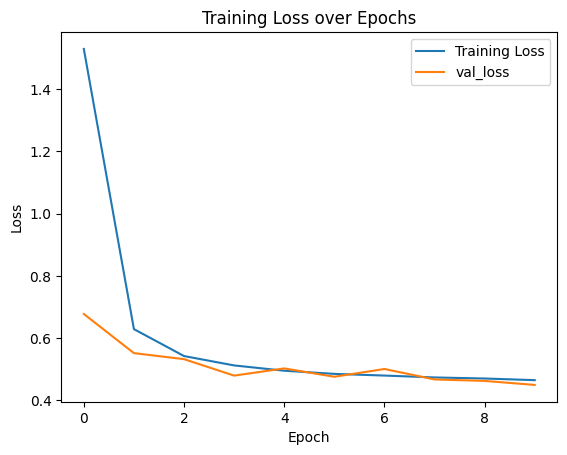

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Convolutional Neural Net

In [ ]:
chinyu_cnn_model = Sequential()
chinyu_cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(chinyu_X_train.shape[1], 1)))
chinyu_cnn_model.add(MaxPooling1D(pool_size=2))
chinyu_cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
chinyu_cnn_model.add(MaxPooling1D(pool_size=2))
chinyu_cnn_model.add(Flatten())
chinyu_cnn_model.add(Dense(128, activation='relu'))
chinyu_cnn_model.add(Dense(len(y.unique()), activation='softmax'))

chinyu_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = chinyu_cnn_model.fit(chinyu_X_train, chinyu_y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/10
16019/16019 [==============================] - 117s 7ms/step - loss: 0.8186 - accuracy: 0.7389 - val_loss: 0.5128 - val_accuracy: 0.7980
Epoch 2/10
16019/16019 [==============================] - 82s 5ms/step - loss: 0.5027 - accuracy: 0.8004 - val_loss: 0.4746 - val_accuracy: 0.8097
Epoch 3/10
16019/16019 [==============================] - 80s 5ms/step - loss: 0.4746 - accuracy: 0.8105 - val_loss: 0.4790 - val_accuracy: 0.8087
Epoch 4/10
16019/16019 [==============================] - 79s 5ms/step - loss: 0.4601 - accuracy: 0.8160 - val_loss: 0.4618 - val_accuracy: 0.8165
Epoch 5/10
16019/16019 [==============================] - 78s 5ms/step - loss: 0.4519 - accuracy: 0.8200 - val_loss: 0.4620 - val_accuracy: 0.8146
Epoch 6/10
16019/16019 [==============================] - 81s 5ms/step - loss: 0.4436 - accuracy: 0.8233 - val_loss: 0.4615 - val_accuracy: 0.8111
Epoch 7/10
16019/16019 [==============================] - 84s 5ms/step - loss: 0.4371 - accuracy: 0.8257 - val_loss: 

In [ ]:
loss, accuracy = chinyu_cnn_model.evaluate(chinyu_X_test, chinyu_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 12s 3ms/step - loss: 0.4239 - accuracy: 0.8337
Test Accuracy: 0.8337395191192627


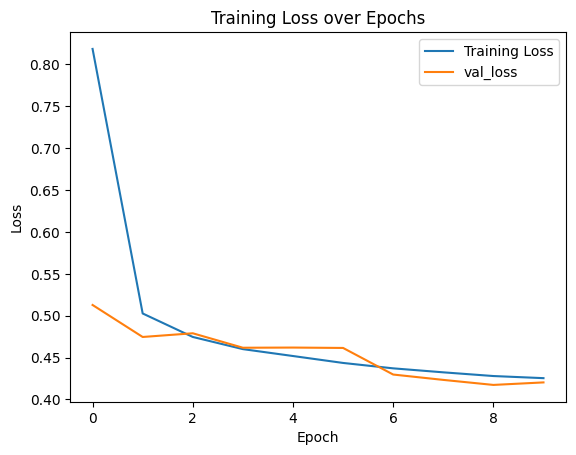

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Predicting Strikezone Area (1,2,3, etc...)

### Multi-Label Neural Net

In [ ]:
from keras.regularizers import l2

In [ ]:
num_zones

13

### Convolutional Neural Net w/o Deep Insight

In [ ]:
kael_cnn_model = Sequential()
kael_cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(kael_X_train.shape[1], 1)))
kael_cnn_model.add(MaxPooling1D(pool_size=2))
kael_cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
kael_cnn_model.add(MaxPooling1D(pool_size=2))
kael_cnn_model.add(Flatten())
kael_cnn_model.add(Dense(128, activation='relu'))
kael_cnn_model.add(Dense(num_zones, activation='softmax'))

kael_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = kael_cnn_model.fit(kael_X_train, kael_y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/5
16019/16019 [==============================] - 75s 5ms/step - loss: 1.4400 - accuracy: 0.5773 - val_loss: 0.4875 - val_accuracy: 0.8031
Epoch 2/5
16019/16019 [==============================] - 71s 4ms/step - loss: 0.4951 - accuracy: 0.7992 - val_loss: 0.5377 - val_accuracy: 0.7690
Epoch 3/5
16019/16019 [==============================] - 70s 4ms/step - loss: 0.4296 - accuracy: 0.8238 - val_loss: 0.3864 - val_accuracy: 0.8419
Epoch 4/5
16019/16019 [==============================] - 74s 5ms/step - loss: 0.3948 - accuracy: 0.8374 - val_loss: 0.2913 - val_accuracy: 0.8847
Epoch 5/5
16019/16019 [==============================] - 74s 5ms/step - loss: 0.3705 - accuracy: 0.8475 - val_loss: 0.3770 - val_accuracy: 0.8398


In [ ]:
loss, accuracy = kael_cnn_model.evaluate(kael_X_test, kael_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 9s 2ms/step - loss: 0.3767 - accuracy: 0.8412
Test Accuracy: 0.8411771059036255


### Convolutional Neural Net with Deep Insight

In [ ]:
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
# Reshape the input data to include a channel dimension
kael_X_train_DI = kael_X_train_DI.reshape(-1, 4, 5, 1)
kael_X_test_DI = kael_X_test_DI.reshape(-1, 4, 5, 1)

In [ ]:
kael_cnn_DI_model = Sequential()
kael_cnn_DI_model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding = 'same', input_shape=(4,5,1)))
kael_cnn_DI_model.add(MaxPooling2D(pool_size=(2,2)))
kael_cnn_DI_model.add(Conv2D(filters=64, kernel_size=(2,2), padding = 'same',activation='relu'))
kael_cnn_DI_model.add(MaxPooling2D(pool_size=(2,2)))
kael_cnn_DI_model.add(Flatten())
kael_cnn_DI_model.add(Dense(128, activation='relu'))
kael_cnn_DI_model.add(Dense(num_zones, activation='softmax'))

kael_cnn_DI_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = kael_cnn_DI_model.fit(kael_X_train_DI, kael_y_train, epochs=15, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/15
16019/16019 [==============================] - 85s 5ms/step - loss: 1.9858 - accuracy: 0.3627 - val_loss: 1.6899 - val_accuracy: 0.4019
Epoch 2/15
16019/16019 [==============================] - 79s 5ms/step - loss: 1.5871 - accuracy: 0.4281 - val_loss: 1.5821 - val_accuracy: 0.4301
Epoch 3/15
16019/16019 [==============================] - 78s 5ms/step - loss: 1.4546 - accuracy: 0.4678 - val_loss: 1.0324 - val_accuracy: 0.6160
Epoch 4/15
16019/16019 [==============================] - 75s 5ms/step - loss: 0.9888 - accuracy: 0.6116 - val_loss: 0.9227 - val_accuracy: 0.6288
Epoch 5/15
16019/16019 [==============================] - 80s 5ms/step - loss: 0.9003 - accuracy: 0.6347 - val_loss: 0.9073 - val_accuracy: 0.6294
Epoch 6/15
16019/16019 [==============================] - 84s 5ms/step - loss: 0.8774 - accuracy: 0.6416 - val_loss: 1.0160 - val_accuracy: 0.5938
Epoch 7/15
16019/16019 [==============================] - 79s 5ms/step - loss: 0.8634 - accuracy: 0.6453 - val_loss: 0

In [ ]:
loss, accuracy = kael_cnn_DI_model.evaluate(kael_X_test_DI, kael_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 13s 3ms/step - loss: 0.8622 - accuracy: 0.6436
Test Accuracy: 0.6436001062393188




---



## Balanced Dataset Models


## Predicting Pitch (Ball or Strike) (Connor)

### Multi-Label Neural Net

### Convolutional Neural Net

## Predicting Pitch Type (Cutter, Fastball, etc...)

### Multi-Label Neural Net

In [ ]:
chinyu_fnn_SMOTE_model = Sequential([
    Dense(64, activation='relu', input_shape=(chinyu_X_train_resampled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(y.unique()), activation='softmax')
])

chinyu_fnn_SMOTE_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = chinyu_fnn_SMOTE_model.fit(chinyu_X_train_resampled, chinyu_y_train_resampled, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/10
67215/67215 [==============================] - 190s 3ms/step - loss: 2.1399 - accuracy: 0.2115 - val_loss: 3.4609 - val_accuracy: 0.2590
Epoch 2/10
67215/67215 [==============================] - 177s 3ms/step - loss: 0.6232 - accuracy: 0.7516 - val_loss: 3.1523 - val_accuracy: 0.7495
Epoch 3/10
67215/67215 [==============================] - 178s 3ms/step - loss: 0.5449 - accuracy: 0.7833 - val_loss: 1.7682 - val_accuracy: 0.8533
Epoch 4/10
67215/67215 [==============================] - 174s 3ms/step - loss: 0.5030 - accuracy: 0.8023 - val_loss: 1.7867 - val_accuracy: 0.8413
Epoch 5/10
67215/67215 [==============================] - 180s 3ms/step - loss: 0.4715 - accuracy: 0.8178 - val_loss: 2.3848 - val_accuracy: 0.8334
Epoch 6/10
67215/67215 [==============================] - 188s 3ms/step - loss: 0.4553 - accuracy: 0.8251 - val_loss: 1.6246 - val_accuracy: 0.9362
Epoch 7/10
67215/67215 [==============================] - 177s 3ms/step - loss: 0.4431 - accuracy: 0.8300 - val_

In [ ]:
loss, accuracy = chinyu_fnn_SMOTE_model.evaluate(chinyu_X_test, chinyu_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 10s 2ms/step - loss: 0.5298 - accuracy: 0.7888
Test Accuracy: 0.7888190746307373


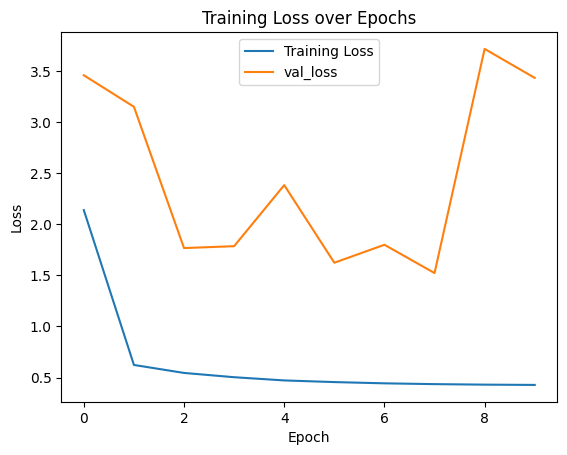

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Convolutional Neural Net

In [ ]:
chinyu_cnn_SMOTE_model = Sequential()
chinyu_cnn_SMOTE_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(chinyu_X_train_resampled.shape[1], 1)))
chinyu_cnn_SMOTE_model.add(MaxPooling1D(pool_size=2))
chinyu_cnn_SMOTE_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
chinyu_cnn_SMOTE_model.add(MaxPooling1D(pool_size=2))
chinyu_cnn_SMOTE_model.add(Flatten())
chinyu_cnn_SMOTE_model.add(Dense(128, activation='relu'))
chinyu_cnn_SMOTE_model.add(Dense(len(y.unique()), activation='softmax'))

chinyu_cnn_SMOTE_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = chinyu_cnn_SMOTE_model.fit(chinyu_X_train_resampled, chinyu_y_train_resampled, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/10
67215/67215 [==============================] - 335s 5ms/step - loss: 0.6145 - accuracy: 0.7674 - val_loss: 1.3039 - val_accuracy: 0.8615
Epoch 2/10
67215/67215 [==============================] - 337s 5ms/step - loss: 0.4514 - accuracy: 0.8213 - val_loss: 0.8598 - val_accuracy: 0.9167
Epoch 3/10
67215/67215 [==============================] - 336s 5ms/step - loss: 0.4255 - accuracy: 0.8326 - val_loss: 1.0898 - val_accuracy: 0.8802
Epoch 4/10
67215/67215 [==============================] - 337s 5ms/step - loss: 0.4088 - accuracy: 0.8398 - val_loss: 1.5234 - val_accuracy: 0.8907
Epoch 5/10
67215/67215 [==============================] - 344s 5ms/step - loss: 0.3986 - accuracy: 0.8442 - val_loss: 1.4880 - val_accuracy: 0.8818
Epoch 6/10
67215/67215 [==============================] - 338s 5ms/step - loss: 0.3914 - accuracy: 0.8473 - val_loss: 1.1385 - val_accuracy: 0.9338
Epoch 7/10
67215/67215 [==============================] - 347s 5ms/step - loss: 0.3856 - accuracy: 0.8497 - val_

In [ ]:
loss, accuracy = chinyu_cnn_SMOTE_model.evaluate(chinyu_X_test, chinyu_y_test)
print("Test Accuracy:", accuracy, loss)

4450/4450 [==============================] - 11s 3ms/step - loss: 0.4772 - accuracy: 0.8127
Test Accuracy: 0.8127120137214661


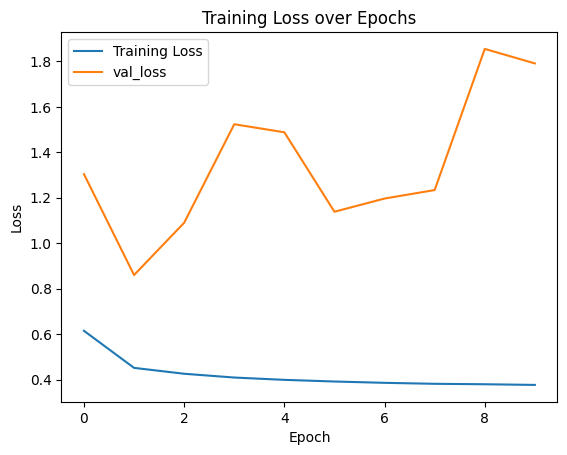

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Predicting Strikezone Area (1,2,3, etc...)

### Multi-Label Neural Net

In [ ]:
kael_y_train_resampled[0:5]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [ ]:
kael_ffnn_SMOTE_model = Sequential([
    Dense(64, activation='relu', input_shape=(kael_X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(kael_y_train.shape[1], activation='softmax')
])

kael_ffnn_SMOTE_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = kael_ffnn_SMOTE_model.fit(kael_X_train_resampled, kael_y_train_resampled, epochs=5, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/5
17240/17240 [==============================] - 82s 5ms/step - loss: 2.6375 - accuracy: 0.0969 - val_loss: 3.2030 - val_accuracy: 0.0000e+00
Epoch 2/5
17240/17240 [==============================] - 60s 3ms/step - loss: 2.5009 - accuracy: 0.0966 - val_loss: 3.2021 - val_accuracy: 0.0000e+00
Epoch 3/5
17240/17240 [==============================] - 59s 3ms/step - loss: 2.5009 - accuracy: 0.0965 - val_loss: 3.2107 - val_accuracy: 0.0000e+00
Epoch 4/5
17240/17240 [==============================] - 59s 3ms/step - loss: 2.5009 - accuracy: 0.0959 - val_loss: 3.2002 - val_accuracy: 0.0000e+00
Epoch 5/5
17240/17240 [==============================] - 52s 3ms/step - loss: 2.5009 - accuracy: 0.0961 - val_loss: 3.1909 - val_accuracy: 0.0000e+00


In [ ]:
loss, accuracy = kael_ffnn_SMOTE_model.evaluate(kael_X_test, kael_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 10s 2ms/step - loss: 2.6434 - accuracy: 0.0424
Test Accuracy: 0.04240615293383598


In [ ]:
predictions = kael_ffnn_SMOTE_model.predict(kael_X_test)
zone_preds = [np.argmax(pred) for pred in predictions]

mapping_zone_vector = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 11, 10: 12, 11: 13, 12: 14}

4450/4450 [==============================] - 10s 2ms/step


In [ ]:
# predicting all pitches to end up in zone 14
pd.Series(zone_preds).map(mapping_zone_vector).value_counts()

1    142385
Name: count, dtype: int64

### Convolutional Neural Net w/o Deep Insight

In [ ]:
kael_X_train_resampled.shape[1]

20

In [ ]:
kael_cnn_SMOTE_model = Sequential()
kael_cnn_SMOTE_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(kael_X_train_resampled.shape[1], 1)))
kael_cnn_SMOTE_model.add(MaxPooling1D(pool_size=2))
kael_cnn_SMOTE_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
kael_cnn_SMOTE_model.add(MaxPooling1D(pool_size=2))
kael_cnn_SMOTE_model.add(Flatten())
kael_cnn_SMOTE_model.add(Dense(128, activation='relu'))
kael_cnn_SMOTE_model.add(Dense(num_zones, activation='softmax'))

kael_cnn_SMOTE_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = kael_cnn_SMOTE_model.fit(kael_X_train_resampled, kael_y_train_resampled, epochs=5, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/5
38790/38790 [==============================] - 187s 5ms/step - loss: 0.9342 - accuracy: 0.6843 - val_loss: 0.4077 - val_accuracy: 0.8394
Epoch 2/5
38790/38790 [==============================] - 175s 4ms/step - loss: 0.3768 - accuracy: 0.8529 - val_loss: 0.3421 - val_accuracy: 0.8665
Epoch 3/5
38790/38790 [==============================] - 173s 4ms/step - loss: 0.3141 - accuracy: 0.8773 - val_loss: 0.4718 - val_accuracy: 0.8407
Epoch 4/5
38790/38790 [==============================] - 175s 5ms/step - loss: 0.2791 - accuracy: 0.8908 - val_loss: 0.4035 - val_accuracy: 0.8647
Epoch 5/5
38790/38790 [==============================] - 175s 5ms/step - loss: 0.2604 - accuracy: 0.8981 - val_loss: 0.5140 - val_accuracy: 0.8392


In [ ]:
loss, accuracy = kael_cnn_SMOTE_model.evaluate(kael_X_test, kael_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 22s 5ms/step - loss: 0.3868 - accuracy: 0.8476
Test Accuracy: 0.847596287727356


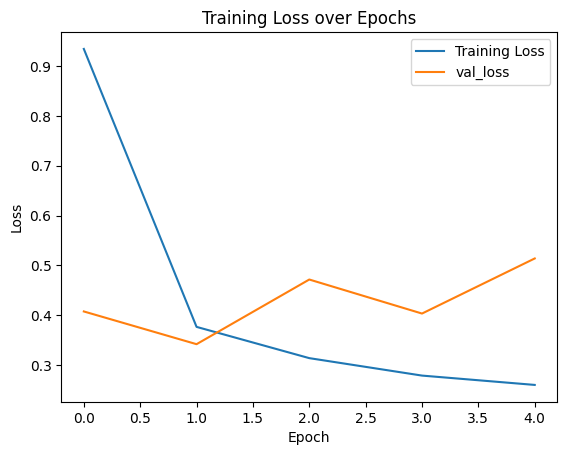

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Convolutional Neural Net with Deep Insight

In [ ]:
kael_X_train_resampled_DI = kael_X_train_resampled_DI.reshape(-1, 4, 5, 1)
#kael_X_test_DI = kael_X_test_DI.reshape(-1, 4, 5, 1)

In [ ]:
kael_cnn_SMOTE_DI_model = Sequential()
kael_cnn_SMOTE_DI_model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding = 'same', input_shape=(4,5,1)))
kael_cnn_SMOTE_DI_model.add(MaxPooling2D(pool_size=(2,2)))
kael_cnn_SMOTE_DI_model.add(Conv2D(filters=64, kernel_size=(2,2), padding = 'same',activation='relu'))
kael_cnn_SMOTE_DI_model.add(MaxPooling2D(pool_size=(2,2)))
kael_cnn_SMOTE_DI_model.add(Flatten())
kael_cnn_SMOTE_DI_model.add(Dense(128, activation='relu'))
kael_cnn_SMOTE_DI_model.add(Dense(num_zones, activation='softmax'))

kael_cnn_SMOTE_DI_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = kael_cnn_SMOTE_DI_model.fit(kael_X_train_resampled_DI, kael_y_train_resampled, epochs=15, batch_size=64, verbose=1, validation_split=0.1)

Epoch 1/15
19395/19395 [==============================] - 121s 6ms/step - loss: 2.0167 - accuracy: 0.2986 - val_loss: 1.6920 - val_accuracy: 0.3623
Epoch 2/15
19395/19395 [==============================] - 123s 6ms/step - loss: 1.6453 - accuracy: 0.3831 - val_loss: 2.0142 - val_accuracy: 0.2918
Epoch 3/15
19395/19395 [==============================] - 118s 6ms/step - loss: 1.6214 - accuracy: 0.3910 - val_loss: 1.8234 - val_accuracy: 0.3341
Epoch 4/15
19395/19395 [==============================] - 115s 6ms/step - loss: 1.6113 - accuracy: 0.3938 - val_loss: 1.4090 - val_accuracy: 0.4573
Epoch 5/15
19395/19395 [==============================] - 119s 6ms/step - loss: 1.6029 - accuracy: 0.3970 - val_loss: 1.6342 - val_accuracy: 0.3539
Epoch 6/15
19395/19395 [==============================] - 114s 6ms/step - loss: 1.5967 - accuracy: 0.3990 - val_loss: 1.6518 - val_accuracy: 0.3857
Epoch 7/15
19395/19395 [==============================] - 114s 6ms/step - loss: 1.5925 - accuracy: 0.4001 - val_

In [ ]:
loss, accuracy = kael_cnn_SMOTE_DI_model.evaluate(kael_X_test_DI, kael_y_test)
print("Test Accuracy:", accuracy)

4450/4450 [==============================] - 15s 3ms/step - loss: 1.6646 - accuracy: 0.3956
Test Accuracy: 0.3955543041229248
